In [38]:
import tensorflow as tf

x = tf.constant(10, dtype=tf.float32)
y = tf.constant(20, dtype=tf.float32)
z = tf.Variable(tf.add(x, y))

# No need for global_variables_initializer() in TensorFlow 2.x

# TensorFlow 2.x automatically initializes variables when they are used in sessions or functions

# Instead of session.run(z), you can simply access the value of z using z.numpy()
print(z.numpy())


30.0


In [39]:
#custom activation functions
def my_softplus(z): 
    return tf.math.log(tf.exp(z) + 1.0)
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))
def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [40]:
#custom layers 
from tensorflow import keras
exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [41]:
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
    def build(self, batch_input_shape): 
        self.kernel = self.add_weight(name="kernel", shape=[batch_input_shape[-1], self.units],intializer="glorot_normal")
        self.bias = self.add_weight(name="bias", shape=[self.units], initializer="zeros") 
        super().build(batch_input_shape) # must be at the end
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
        "activation": keras.activations.serialize(self.activation)}

In [42]:
#custom model with subclassclassing api 
class ResidualRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
    def call(self, inputs):
        Z = self.hidden1(inputs) 
        for _ in range(1 + 3):
            Z = self.block1(Z) 
            Z = self.block2(Z) 
            return self.out(Z)

In [43]:
#creating graphs 
a=tf.constant(10.0)
b=tf.constant(3.0)
c=tf.add(a,b)
d=tf.multiply(a,b)
tf.print("graph operations:",c,d)

graph operations: 13 30


In [44]:
#regression model 
import tensorflow as tf 
from tensorflow import keras 
import matplotlib.pyplot as plt 
import numpy as np 
np.random.seed(42)
x_train=np.linspace(1,10,100)
y_train=2*x_train+2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
model=Sequential()
model.add(Input(1,))
model.add(Dense(units=1,activation='linear'))
model.compile(optimizer='sgd',loss='mean_squared_error')
history=model.fit(x_train,y_train,epochs=100,verbose=True)


Epoch 1/100
4/4 [==============================] - 0s 16ms/step - loss: 18.0129
Epoch 2/100
4/4 [==============================] - 0s 6ms/step - loss: 0.6025
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.5954
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5604
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5551
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5637
Epoch 7/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5104
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5757
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 0.4979
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 0.4746
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - loss: 0.4885
Epoch 12/100
4/4 [==============================] - 0s 5ms/step - loss: 0.4784
Epoch 13/100
4/4 [==============================] - 0s 5ms/

dict_keys(['loss'])


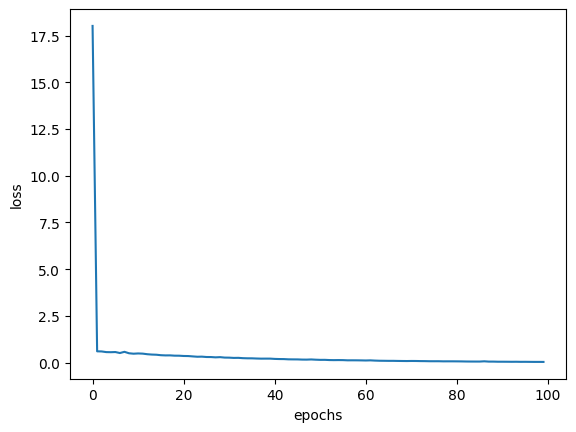

In [45]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel("loss")
plt.show()

In [46]:
#gradient descent with tensorflow
import tensorflow as tf 
import numpy as np 
np.random.seed(40)
x=np.linspace(0,10,100)
y=2*x+5
#convert numpy to tensor
x_train=tf.constant(x,dtype=tf.float32)
y_train=tf.constant(y,dtype=tf.float32)
#initialize weights & bias 
w=tf.Variable(np.random.randn(),name="weight")
b=tf.Variable(np.random.randn(),name="bias")
#linear model 
def linear_model(x):
    return w*x+b
def mean_squared_error(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))
optimizer=tf.optimizers.SGD(learning_rate=0.01)
#training loop 
epochs=100
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions=linear_model(x_train)
        loss=mean_squared_error(y_train,predictions)
        
    gradients=tape.gradient(loss,[w,b]) #compute gradients
    optimizer.apply_gradients(zip(gradients,[w,b]))

trained_w,trained_b=w.numpy(),b.numpy()
print("trained wegihts & bias ")
print("weights:",trained_w)
print("bias:",trained_b)



trained wegihts & bias 
weights: 2.4231925
bias: 2.1854753


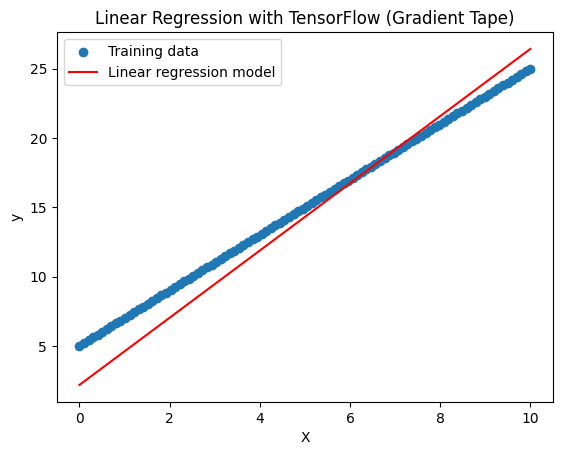

In [47]:
plt.scatter(x_train, y_train, label='Training data')
plt.plot(x_train, trained_w * x_train + trained_b, 'r', label='Linear regression model')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression with TensorFlow (Gradient Tape)')
plt.legend()
plt.show()

In [48]:
from datetime import datetime
# Define TensorBoard log directory
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir)